<a href="https://colab.research.google.com/github/Subhom-Ghosh/Used-Car-Price-Prediction/blob/main/Used_Car_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import pandas as pd


In [25]:
df = pd.read_csv("/content/drive/MyDrive/used_cars.csv")

In [26]:
df.head()

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,Ford,Utility Police Interceptor Base,2013,"51,000 mi.",E85 Flex Fuel,300.0HP 3.7L V6 Cylinder Engine Flex Fuel Capa...,6-Speed A/T,Black,Black,At least 1 accident or damage reported,Yes,"$10,300"
1,Hyundai,Palisade SEL,2021,"34,742 mi.",Gasoline,3.8L V6 24V GDI DOHC,8-Speed Automatic,Moonlight Cloud,Gray,At least 1 accident or damage reported,Yes,"$38,005"
2,Lexus,RX 350 RX 350,2022,"22,372 mi.",Gasoline,3.5 Liter DOHC,Automatic,Blue,Black,None reported,NaN,"$54,598"
3,INFINITI,Q50 Hybrid Sport,2015,"88,900 mi.",Hybrid,354.0HP 3.5L V6 Cylinder Engine Gas/Electric H...,7-Speed A/T,Black,Black,None reported,Yes,"$15,500"
4,Audi,Q3 45 S line Premium Plus,2021,"9,835 mi.",Gasoline,2.0L I4 16V GDI DOHC Turbo,8-Speed Automatic,Glacier White Metallic,Black,None reported,NaN,"$34,999"


In [27]:
df['milage'].dtype
df['price'].dtype

dtype('O')

In [28]:
df['milage'] = df['milage'].str.replace(',','',regex=False).str.replace('mi.','',regex=False).astype(float)

In [29]:
df['price'] = df['price'].str.replace('$','',regex=False).str.replace(',','',regex=False).astype(int)

In [30]:
df['price'].dtype

dtype('int64')

In [31]:
df['car-age'] = 2025 - df['model_year']

In [32]:
df['horsepower'] = df['engine'].str.extract(r'(\d+\.?\d*)HP')
df['horsepower'] = df['horsepower'].astype(float)


In [33]:
df.drop(columns=['engine'],inplace=True)
df.drop(columns=['ext_col', 'int_col'],inplace = True)

In [34]:
df['accident']=df['accident'].apply(
    lambda x: 0 if 'None' in str(x) else 1
)

In [35]:
df['clean_title'] = df['clean_title'].map({
    'Yes': 1,
    'No': 0
})


In [36]:
df['clean_title'].fillna(0, inplace=True)


/tmp/ipython-input-3891924715.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['clean_title'].fillna(0, inplace=True)


In [37]:
df['miles_per_year'] = df['milage'] / (df['car-age'] + 1)

In [38]:
le_cols = ['fuel_type', 'transmission', 'accident']
le = LabelEncoder()
for col in le_cols:
    df[col] = le.fit_transform(df[col])

# 2. For High Cardinality (Brand, Model) -> Use Frequency or Target Encoding
# Frequency Encoding: Replace brand name with how often it appears
# (Popular cars often hold value differently than rare ones)
brand_counts = df['brand'].value_counts()
df['brand_encoded'] = df['brand'].map(brand_counts)

model_counts = df['model'].value_counts()
df['model_encoded'] = df['model'].map(model_counts)

# Drop original text columns
df.drop(columns=['brand', 'model'], inplace=True)

In [39]:
min_price = df['price'].quantile(0.01)
max_price = df['price'].quantile(0.99)
df = df[(df['price'] > min_price) & (df['price'] < max_price)]

# 2. Remove unreasonable mileage
df = df[df['milage'] < 300000]

In [40]:
import numpy as np

y = np.log1p(df['price'])
X = df.drop('price', axis=1)


In [71]:
import pickle
from sklearn.preprocessing import LabelEncoder

# 1. Reload the data to get the original text (Brand names, Model names)
df_original = pd.read_csv("/content/drive/MyDrive/used_cars.csv")

# 2. Define the columns you need to turn into dropdowns
cat_cols = ['brand', 'model', 'fuel_type', 'transmission']
mappings = {}

# 3. Create the mappings (Text -> Number)
for col in cat_cols:
    le = LabelEncoder()
    # Fit the encoder on the text data
    # (We cast to string to handle any mixed types)
    le.fit(df_original[col].astype(str))

    # Save the encoder AND the list of unique names into our dictionary
    mappings[col] = {
        'encoder': le,
        'classes': le.classes_.tolist() # List of names like ['BMW', 'Ford']
    }

# 4. Save this 'dictionary of dictionaries' to a file
with open('car_mappings.pkl', 'wb') as f:
    pickle.dump(mappings, f)

print("Mappings saved! Download 'car_mappings.pkl' and put it next to your app.py")

Mappings saved! Download 'car_mappings.pkl' and put it next to your app.py


In [72]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [73]:
import xgboost as xgb
xgb_train = xgb.DMatrix(X_train, y_train )
xgb_test = xgb.DMatrix(X_test, y_test)

In [74]:
params = {
    'objective': 'reg:squarederror',
    'max_depth': 7,          # Increased slightly from 6 to capture more complexity
    'learning_rate': 0.03,   # Lower rate often yields better accuracy (requires more rounds)
    'subsample': 0.7,        # Lower slightly to prevent overfitting
    'colsample_bytree': 0.7,
    'reg_alpha': 1,          # L1 Regularization: Good for handling outliers
    'reg_lambda': 1,         # L2 Regularization
    'seed': 42

}

# Since we lowered learning_rate, increase num_rounds
num_rounds = 1000
# Add early_stopping_rounds to stop automatically when it stops improving
model = xgb.train(
    params=params,
    dtrain=xgb_train,
    num_boost_round=num_rounds,
    evals=[(xgb_test, "Test")],
    early_stopping_rounds=50
)

[0]	Test-rmse:0.74158
[1]	Test-rmse:0.72600
[2]	Test-rmse:0.71107
[3]	Test-rmse:0.69627
[4]	Test-rmse:0.68208
[5]	Test-rmse:0.66878
[6]	Test-rmse:0.65855
[7]	Test-rmse:0.64587
[8]	Test-rmse:0.63443
[9]	Test-rmse:0.62371
[10]	Test-rmse:0.61353
[11]	Test-rmse:0.60260
[12]	Test-rmse:0.59205
[13]	Test-rmse:0.58157
[14]	Test-rmse:0.57200
[15]	Test-rmse:0.56361
[16]	Test-rmse:0.55516
[17]	Test-rmse:0.54739
[18]	Test-rmse:0.54048
[19]	Test-rmse:0.53570
[20]	Test-rmse:0.52779
[21]	Test-rmse:0.51990
[22]	Test-rmse:0.51273
[23]	Test-rmse:0.50534
[24]	Test-rmse:0.49956
[25]	Test-rmse:0.49271
[26]	Test-rmse:0.48629
[27]	Test-rmse:0.47984
[28]	Test-rmse:0.47354
[29]	Test-rmse:0.46873
[30]	Test-rmse:0.46396
[31]	Test-rmse:0.45831
[32]	Test-rmse:0.45327
[33]	Test-rmse:0.44911
[34]	Test-rmse:0.44396
[35]	Test-rmse:0.43971
[36]	Test-rmse:0.43610
[37]	Test-rmse:0.43150
[38]	Test-rmse:0.42737
[39]	Test-rmse:0.42341
[40]	Test-rmse:0.41956
[41]	Test-rmse:0.41659
[42]	Test-rmse:0.41257
[43]	Test-rmse:0.4094

In [75]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

preds = model.predict(xgb_test)

print("R2 Score:", r2_score(y_test, preds))
print("MAE:", mean_absolute_error(y_test, preds))
print("RMSE:", np.sqrt(mean_squared_error(y_test, preds)))


R2 Score: 0.8481991795802528
MAE: 0.2072462310002139
RMSE: 0.2950462832334207


<Figure size 1000x800 with 0 Axes>

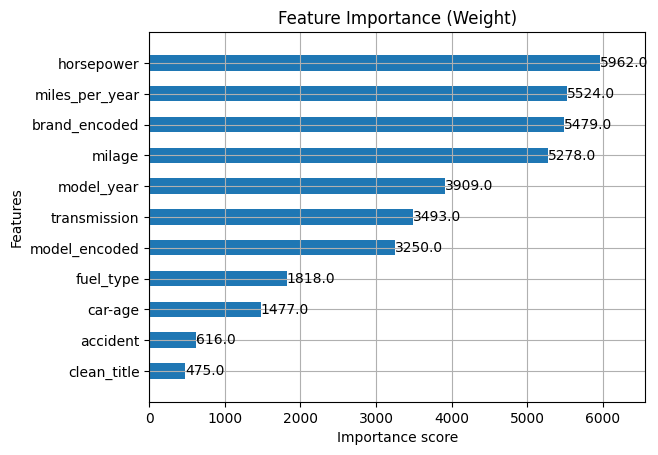

[('horsepower', 5962.0), ('miles_per_year', 5524.0), ('brand_encoded', 5479.0), ('milage', 5278.0), ('model_year', 3909.0), ('transmission', 3493.0), ('model_encoded', 3250.0), ('fuel_type', 1818.0), ('car-age', 1477.0), ('accident', 616.0)]


In [76]:
import matplotlib.pyplot as plt

# 1. Plot feature importance
# 'weight' is the default type (number of times a feature appears in a tree)
# You can also try importance_type='gain' (how much the feature improved accuracy)
plt.figure(figsize=(10, 8))
xgb.plot_importance(model, max_num_features=15, height=0.5, importance_type='weight')
plt.title("Feature Importance (Weight)")
plt.show()

# Optional: Print the dictionary of scores for precision
scores = model.get_score(importance_type='weight')
sorted_scores = sorted(scores.items(), key=lambda x: x[1], reverse=True)
print(sorted_scores[:10])

In [77]:
sample = X_test.iloc[0]

# convert the sample Series to a DataFrame (with one row) to preserve feature names
sample_df = sample.to_frame().T

# convert to DMatrix, which will now infer feature names from the DataFrame
sample_dmatrix = xgb.DMatrix(sample_df)

In [78]:
log_pred = model.predict(sample_dmatrix)[0]

# convert back to actual price
predicted_price = np.expm1(log_pred)

print("Predicted Price: $", int(predicted_price))

Predicted Price: $ 45149


In [79]:
actual_price = np.expm1(y_test.iloc[0])

print("Actual Price: $", int(actual_price))

Actual Price: $ 43998


In [80]:
import random

idxs = random.sample(range(len(X_test)), 10)

for i in idxs:
    sample = X_test.iloc[i]
    actual = np.expm1(y_test.iloc[i])
    # Convert the sample Series to a DataFrame with one row to preserve feature names
    sample_df_for_prediction = sample.to_frame().T
    pred = np.expm1(model.predict(xgb.DMatrix(sample_df_for_prediction))[0])
    print(f"Actual: ${int(actual)} | Predicted: ${int(pred)}")

Actual: $35000 | Predicted: $24573
Actual: $64999 | Predicted: $37781
Actual: $20489 | Predicted: $20444
Actual: $32999 | Predicted: $30411
Actual: $34499 | Predicted: $36111
Actual: $125899 | Predicted: $62815
Actual: $10999 | Predicted: $8870
Actual: $9500 | Predicted: $9726
Actual: $16000 | Predicted: $15467
Actual: $10999 | Predicted: $14912


In [81]:
error_pct = abs(pred - actual) / actual * 100
print(f"Percentage Error: {error_pct:.2f}%")


Percentage Error: 35.57%


In [82]:
import joblib

joblib.dump(model, "car_price_model.pkl")

['car_price_model.pkl']

In [83]:
from google.colab import files

files.download("car_price_model.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [84]:
df.head()

,model_year,milage,fuel_type,transmission,accident,clean_title,price,car-age,horsepower,miles_per_year,brand_encoded,model_encoded
0,2013,51000.0,1,16,1,1.0,10300,12,300.0,3923.076923,386,3
1,2021,34742.0,2,32,1,1.0,38005,4,NaN,6948.400000,72,3
2,2022,22372.0,2,40,0,0.0,54598,3,NaN,5593.000000,163,1
3,2015,88900.0,3,23,0,1.0,15500,10,354.0,8081.818182,59,1
4,2021,9835.0,2,32,0,0.0,34999,4,NaN,1967.000000,200,1


In [85]:
from google.colab import files
files.download('car_mappings.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>